In [1]:
#!pip install bambi git+https://github.com/yannmclatchie/kulprit.git

In [2]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

# define model data
data = pd.DataFrame({
    "y": np.random.normal(size=50),
    "x1": np.random.normal(size=50),
    "x2": np.random.normal(size=50)
})
# define and fit model with MCMC
model = bmb.Model("y ~ x1 + x2", data, family="gaussian")
num_draws, num_chains = 1_000, 2
idata = model.fit(draws=num_draws, chains=num_chains)

/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_sigma, x2, x1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


In [3]:
# build reference model object
ref_model = kpt.ReferenceModel(model, idata)
# project the reference model to some parameter subset and plot posterior
sub_model = ref_model.project(terms=["x1"])

/Users/yannmclatchie/Desktop/kulprit/src/kulprit/projection/dispersion.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  + 1 / self.data.structure.num_obs * (f - f_perp).T @ (f - f_perp)


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'x1'}>,
       <AxesSubplot:title={'center':'y_sigma'}>,
       <AxesSubplot:title={'center':'y_sigma_log__'}>], dtype=object)

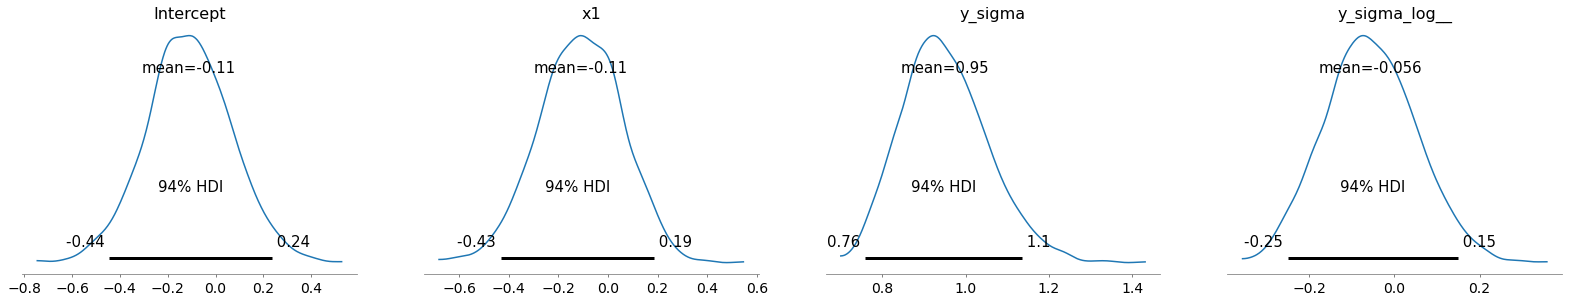

In [4]:
# visualise projected parameters
az.plot_posterior(sub_model.idata)

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'x1'}>,
       <AxesSubplot:title={'center':'x2'}>,
       <AxesSubplot:title={'center':'y_sigma'}>], dtype=object)

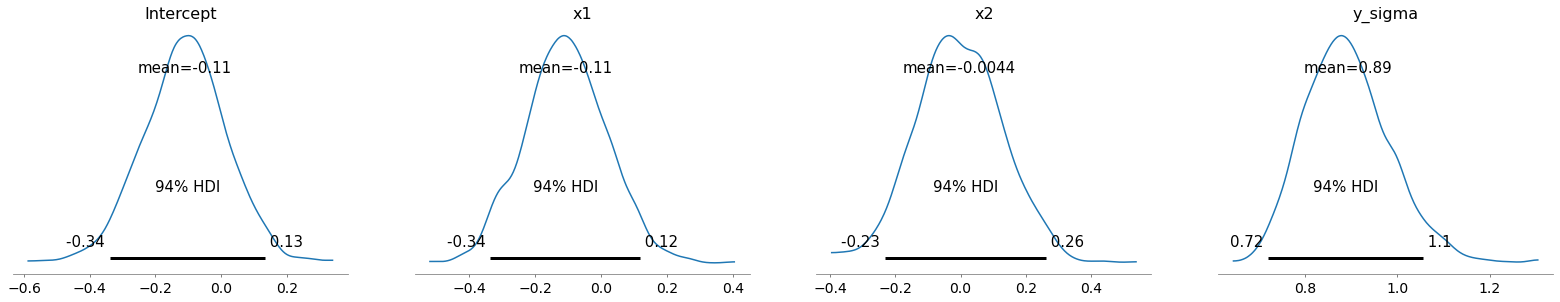

In [5]:
# compared to reference model
az.plot_posterior(idata, var_names=["Intercept", "x1", "x2", "y_sigma"])

In [6]:
# compare full and submodel predictive performance
az.compare(dict(full=idata, sub=sub_model.idata))

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full,0,-67.208745,3.771490,0.000000,1.000000e+00,5.360695,0.000000,False,log
sub,1,-67.640120,3.482815,0.431375,1.110223e-16,4.701774,0.700822,False,log
